**CS22_01_PFC**

# Libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import triku as tk

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.9.2 umap==0.5.4 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.1 statsmodels==0.14.0 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.10


In [3]:
results_file = '/group/testa/Project/CBOProgPools/h5ad/CS22_01_20240208_v1.h5ad'  # the file that will store the analysis results

In [4]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

In [5]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations
# of the data. It also comes with its own HDF5-based file format: .h5ad.
adata = sc.read_10x_mtx(
    '/group/testa/Project/CBOProgPools/data/CS22_PFC/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/group-testa-Project-CBOProgPools-data-CS22_PFC-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 1945 × 33694
    var: 'gene_ids'

# Data Preparation

normalizing counts per cell
    finished (0:00:00)


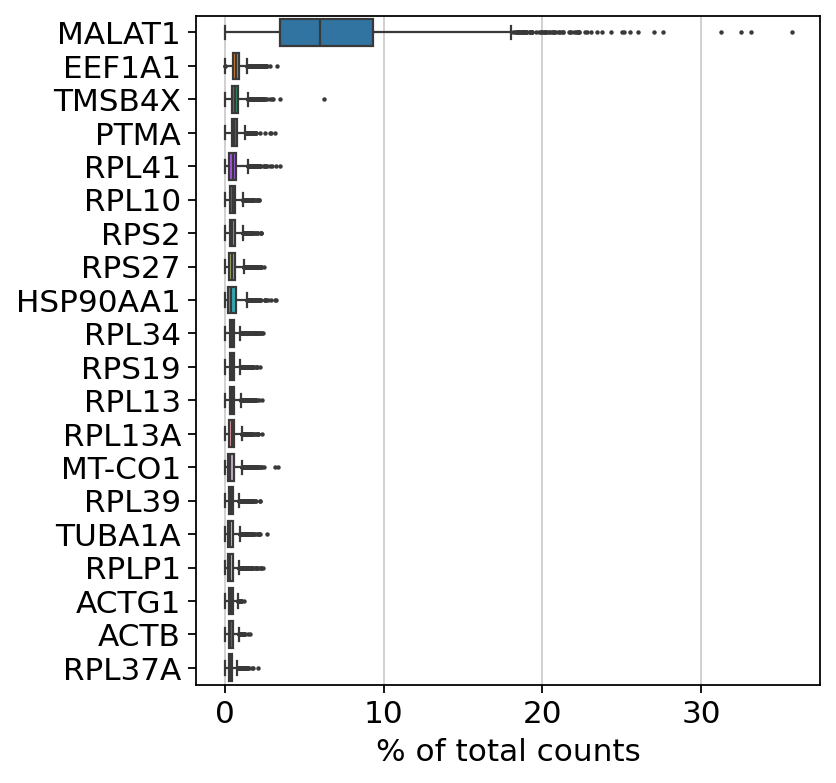

In [8]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )


In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 23066 genes that are detected in less than 50 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var['ribo'] = adata.var_names.str.startswith('RPL')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

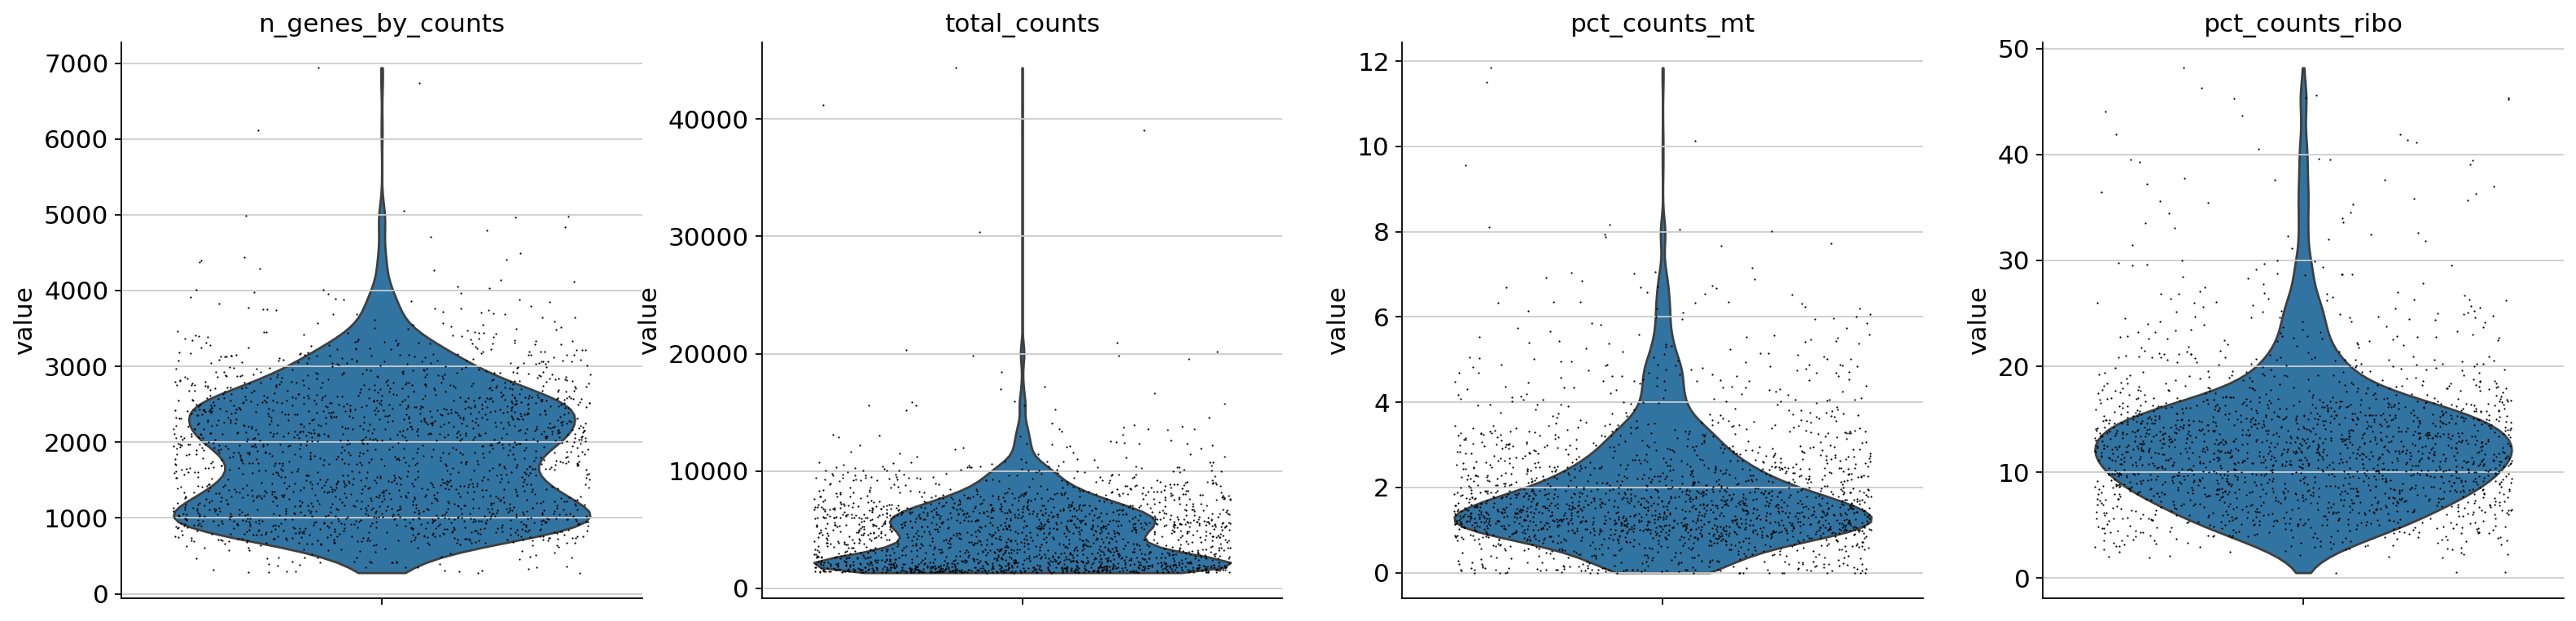

In [11]:
# A violin plot of some of the computed quality measures:
   # the number of genes expressed in the count matrix
   # the total counts per cell
   # the percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

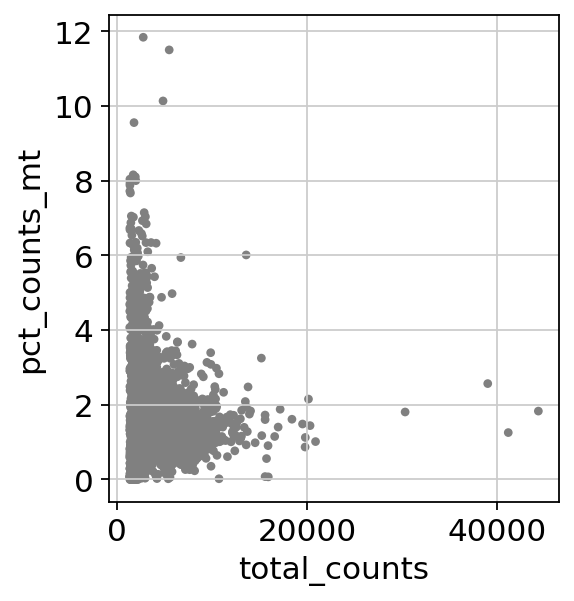

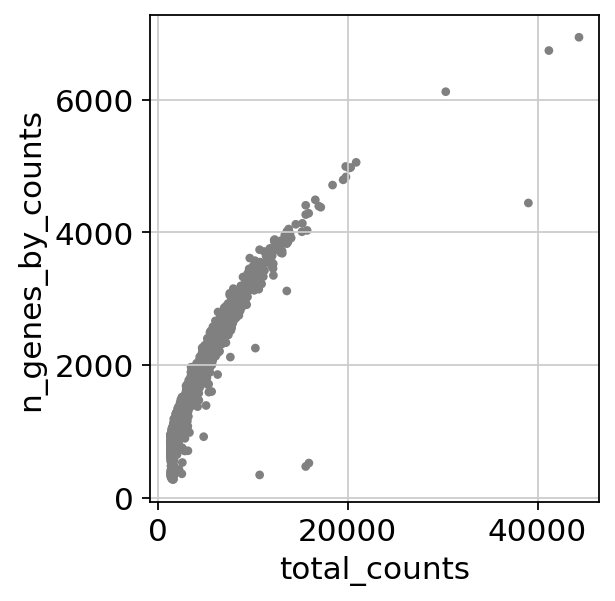

In [12]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.total_counts <= 20000]

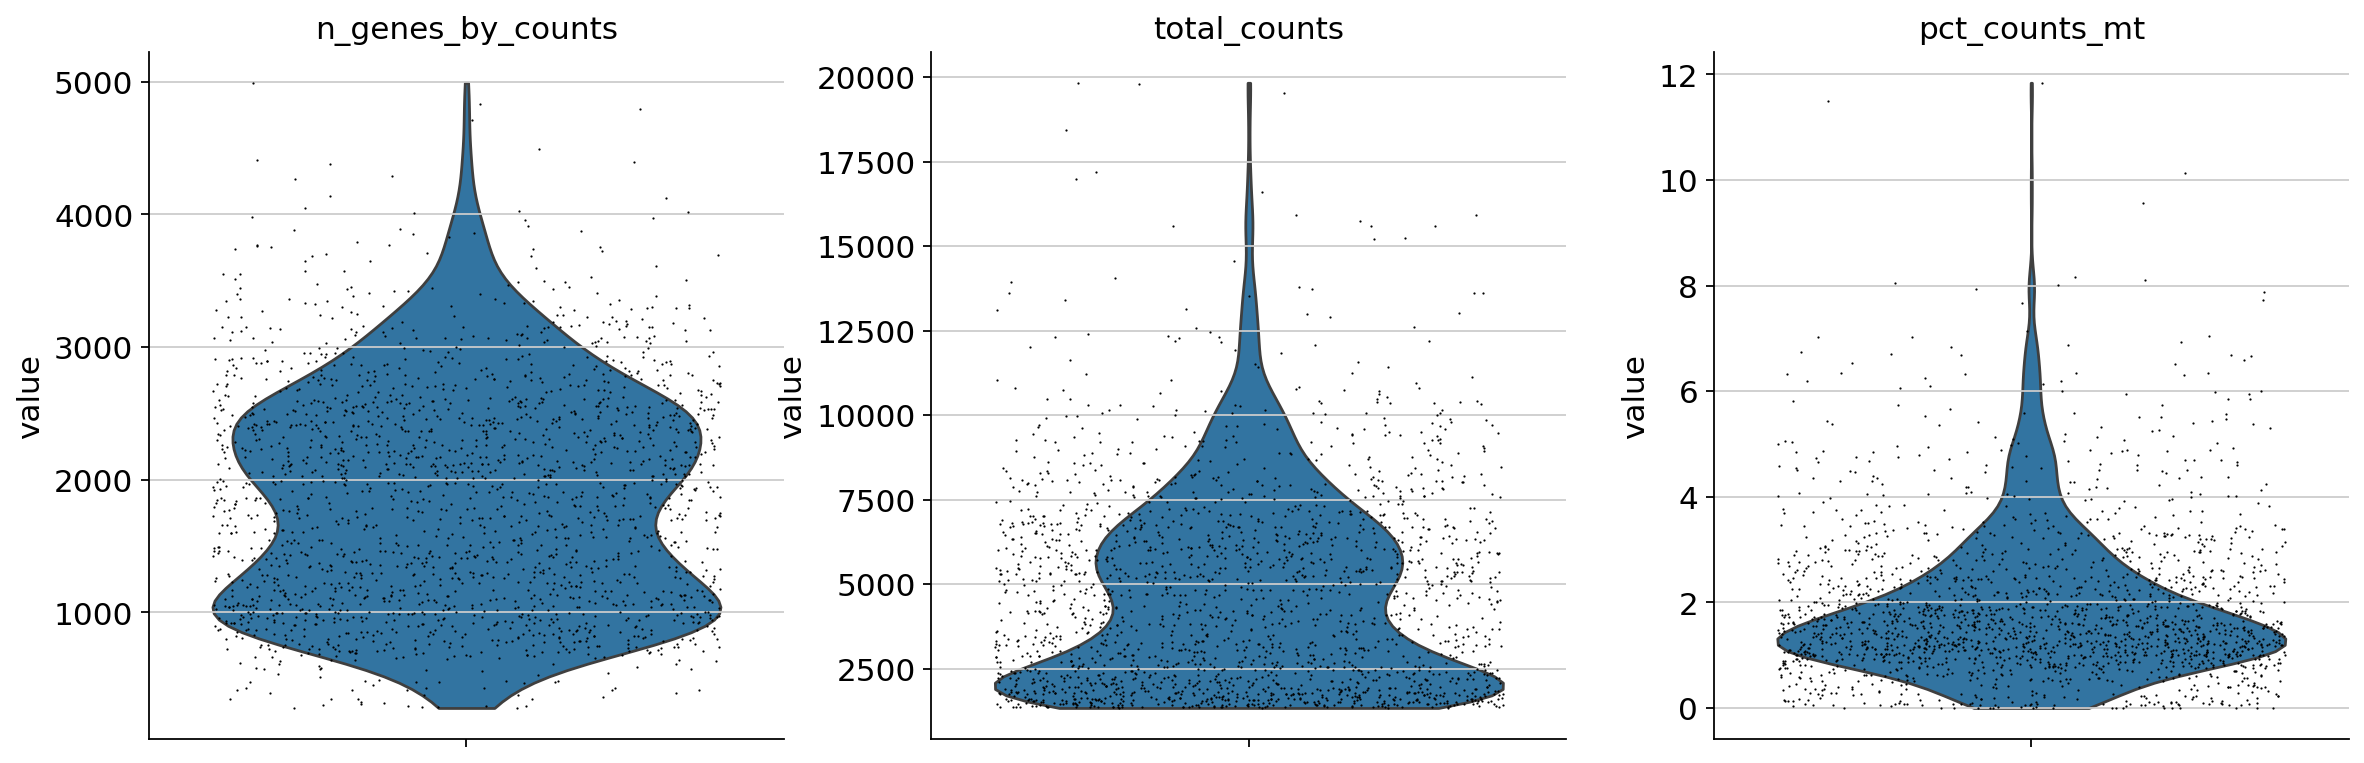

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [15]:
s_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/S_genes",index_col=0,header=None)
g2m_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/G2M_genes",index_col=0,header=None)
sc.tl.score_genes_cell_cycle(adata,s_genes.index,g2m_genes.index)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    684 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    641 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [16]:
adata.obs.keys()

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score',
       'G2M_score', 'phase'],
      dtype='object')

In [17]:
adata.obs.phase.value_counts()

G1     1125
G2M     528
S       285
Name: phase, dtype: int64

In [18]:
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 15.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.0%
    Scrublet finished (0:00:06)


In [19]:
adata.obs.predicted_doublet.value_counts()

False    1932
True        6
Name: predicted_doublet, dtype: int64

In [20]:
adata.raw = adata.copy()
adata.layers['Raw'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=20000) # highest meaningful coverage (see tot_counts)
adata.layers['normalized'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['logNorm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [21]:
adata

AnnData object with n_obs × n_vars = 1938 × 10628
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'scrublet', 'log1p'
    layers: 'Raw', 'normalized', 'logNorm'

In [22]:
sc.pp.pca(adata, use_highly_variable=False)

sc.pp.neighbors(adata, metric='cosine', n_neighbors=int(0.5 * len(adata) ** 0.5)) #25 , 50. 75, 100
 
## Triku

tk.tl.triku(adata, use_raw=False)

Top20Triku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(20).index
Top20Triku

computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


Index(['PIF1', 'GAS2L3', 'RBFOX1', 'JPH4', 'FXYD7', 'RP11-286B14.1', 'SLA',
       'NOL4', 'GRIA2', 'EBF2', 'CALB2', 'SYT4', 'GPR12', 'AC004158.3',
       'CENPA', 'KIF20A', 'SH3BP5', 'SST', 'RELN', 'PPP1R1B'],
      dtype='object')

In [23]:
adata.var_names[adata.var['highly_variable'] == True]

Index(['HES4', 'PRKCZ', 'TP73', 'GPR153', 'ACOT7', 'FBXO44', 'DRAXIN', 'PDPN',
       'IGSF21', 'AKR7A2',
       ...
       'NCAM2', 'TCP10L', 'C21orf59', 'DONSON', 'CHAF1B', 'KCNJ6', 'PSMG1',
       'SH3BGR', 'ADARB1', 'C21orf58'],
      dtype='object', length=1196)

# Principle Component Analysis

In [24]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main 
# axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


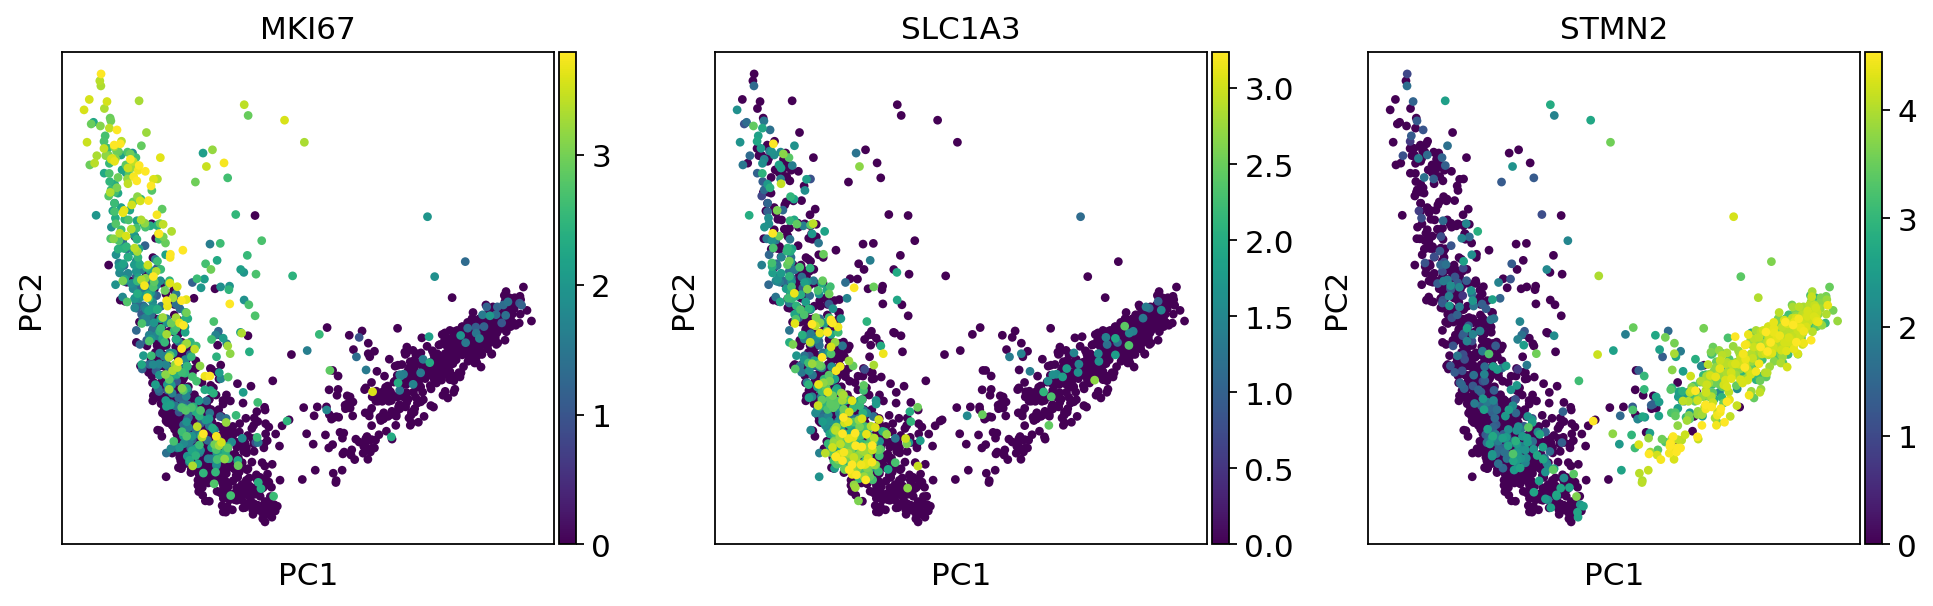

In [25]:
# MKI67 = cycling cell (usually progenitors, aRG / bRG / IP)
# EOMES = IP specific
# SLC1A3 = Radial Glia in general, including glia
# HOPX = bRG specific
# DCX = immature neurons
# STMN2 neurons in general

sc.pl.pca(adata, color=['MKI67','SLC1A3','STMN2'],use_raw=False,vmin="p1",vmax="p99") 

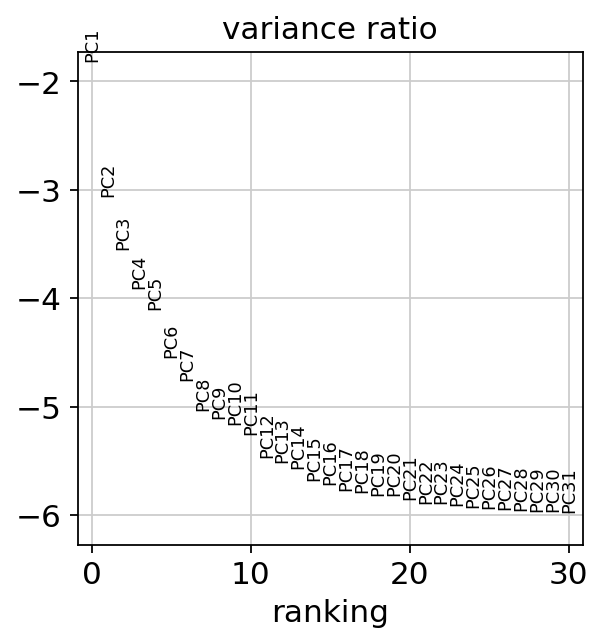

In [26]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [28]:
adata

AnnData object with n_obs × n_vars = 1938 × 10628
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'triku_params'
    obsm: 'X_pca', 'X_triku'
    varm: 'PCs'
    layers: 'Raw', 'normalized', 'logNorm'
    obsp: 'distances', 'connectivities'

# Computing Neighborhood Graph 

In [29]:
int(0.5 * len(adata) ** 0.5)

22

In [30]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 
# You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=15)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


# Embedding Neighborhood Graph

In [31]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")
# small resolution ==> less clusters 

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [32]:
adata.obs.leiden.value_counts()

0    474
1    280
2    251
3    214
4    209
5    183
6    132
7    102
8     57
9     36
Name: leiden, dtype: int64

In [33]:
# We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it 
# better preserves trajectories. In some ocassions, you might still observe disconnected clusters and
# similar connectivity violations. They can usually be remedied by running:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


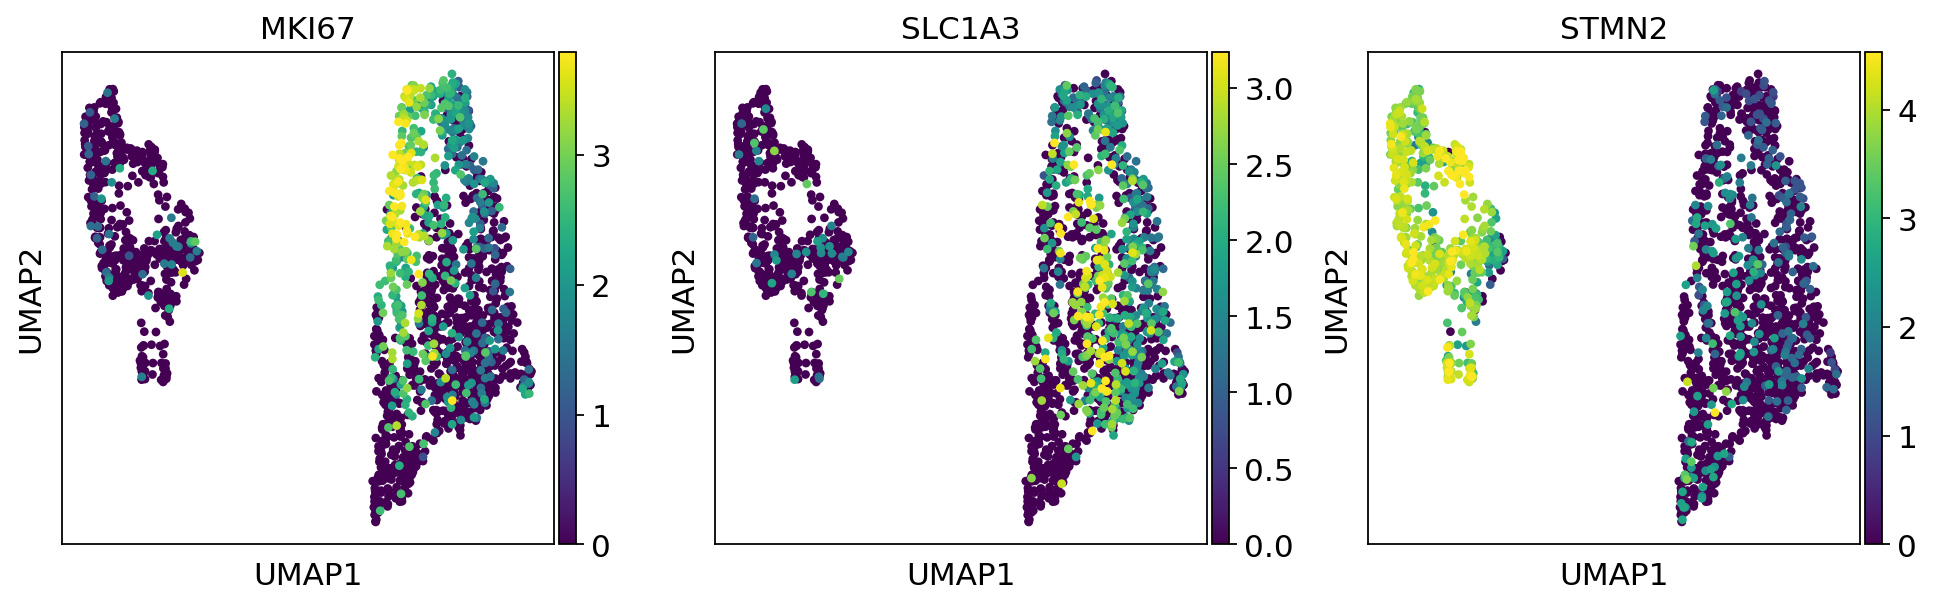

In [35]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) 
# gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to 
# use .raw.
sc.pl.umap(adata, color=['MKI67','SLC1A3','STMN2'], use_raw=False,vmin="p1",vmax="p99")

# Clustering Neighborhood Graph

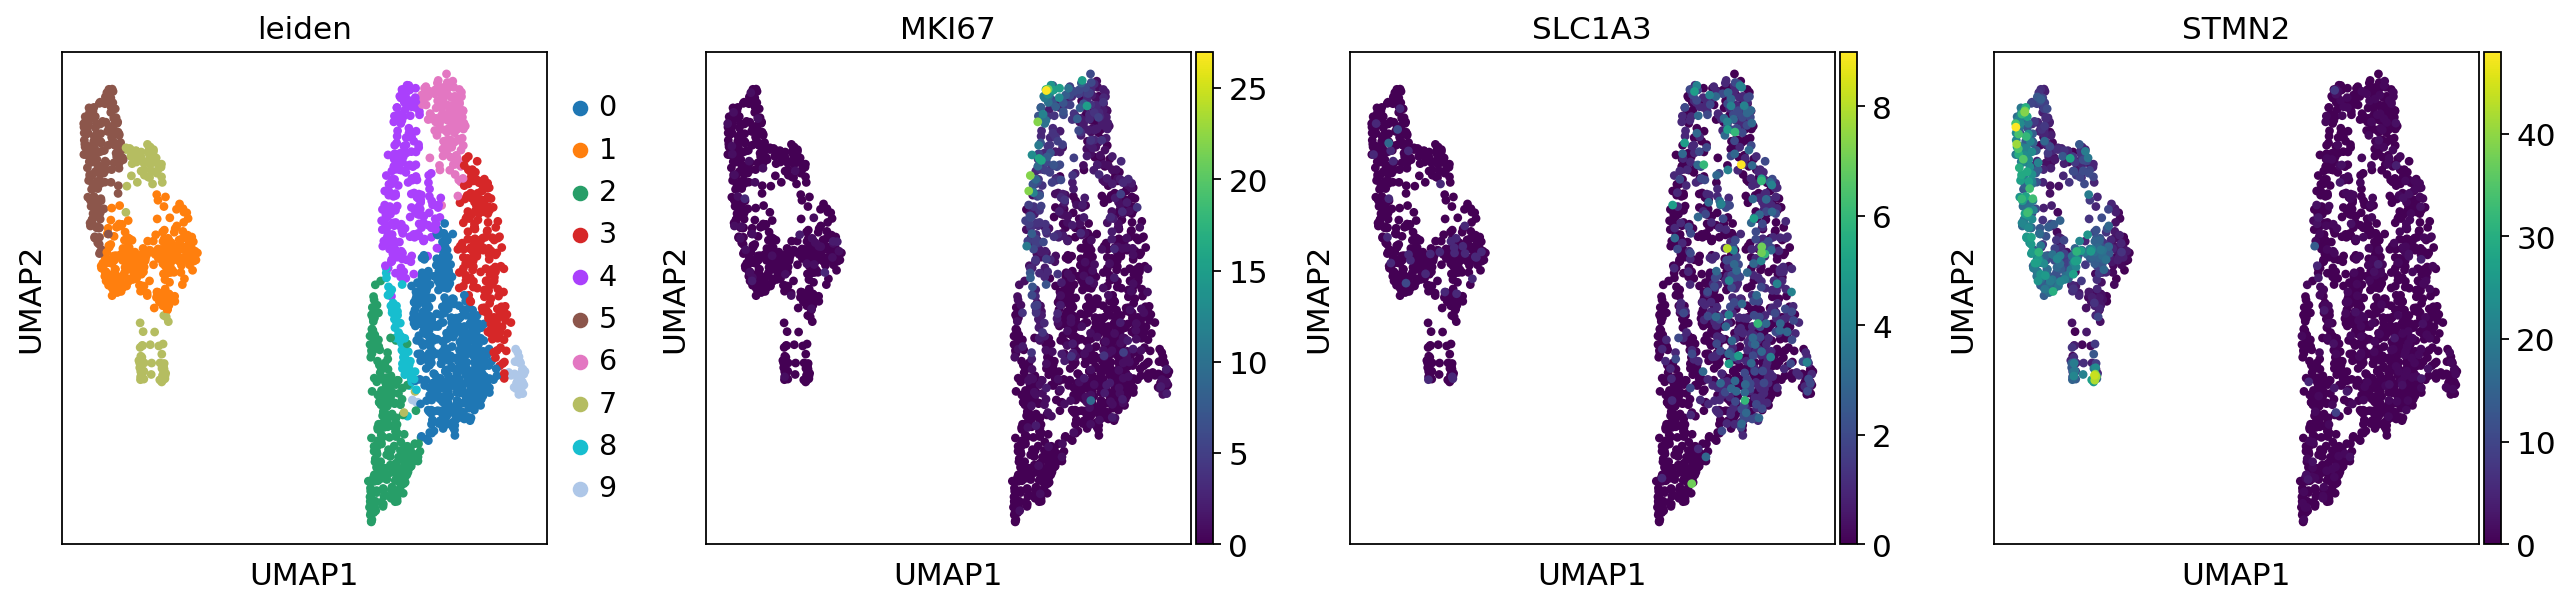

In [36]:
# Plot the clusters, which agree quite well with the result of Seurat.
sc.pl.umap(adata, color=['leiden', 'MKI67','SLC1A3','STMN2'])

# Finding Gene Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


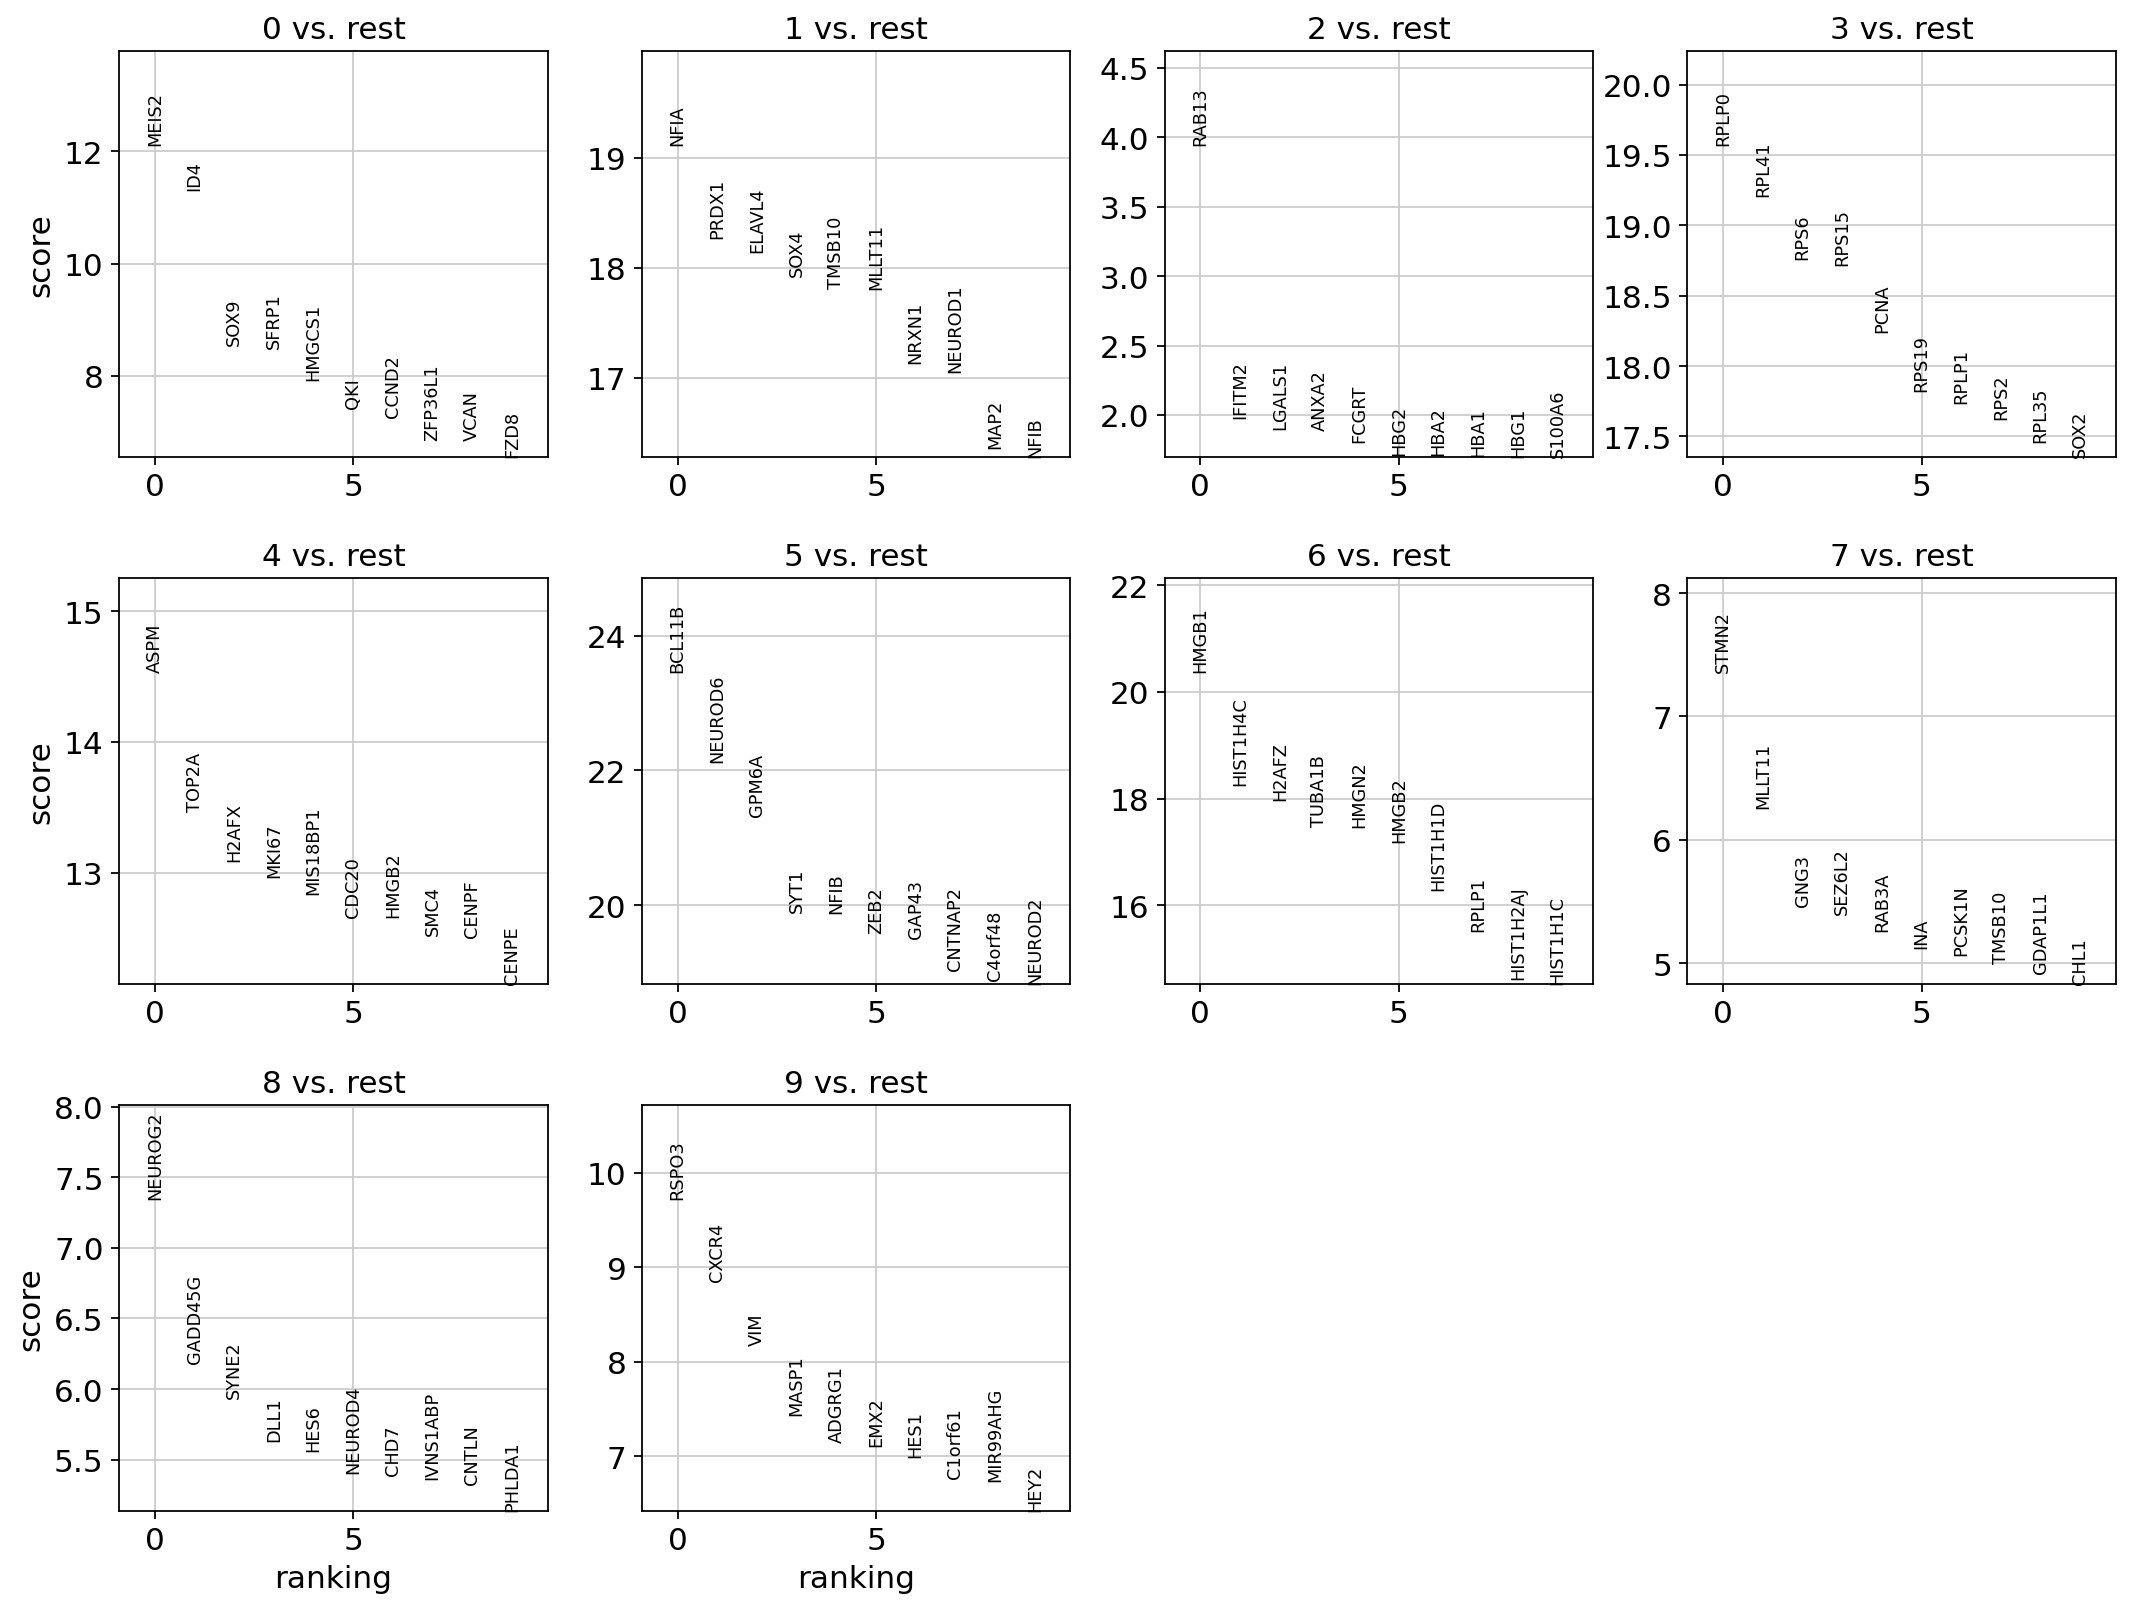

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [38]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p     1_n           1_p     2_n       2_p    3_n  \
0   MEIS2  2.881090e-31    NFIA  2.245543e-55   RAB13  0.000103  RPLP0   
1     ID4  2.213468e-27   PRDX1  1.499161e-50  IFITM2  0.049071  RPL41   
2    SOX9  6.712178e-17  ELAVL4  2.468410e-50  LGALS1  0.058693   RPS6   
3   SFRP1  9.101757e-17    SOX4  4.240499e-52   ANXA2  0.059310  RPS15   
4  HMGCS1  9.324084e-15  TMSB10  2.945887e-51   FCGRT  0.071948   PCNA   

            3_p       4_n           4_p      5_n           5_p       6_n  \
0  3.403609e-53      ASPM  1.471753e-33   BCL11B  1.999458e-58     HMGB1   
1  3.217103e-52     TOP2A  2.946644e-30  NEUROD6  4.179587e-54  HIST1H4C   
2  9.515965e-51     H2AFX  2.890031e-29    GPM6A  2.267089e-52     H2AFZ   
3  1.768098e-50     MKI67  1.140403e-28     SYT1  1.004081e-48    TUBA1B   
4  3.726074e-47  MIS18BP1  2.337728e-28     NFIB  7.928412e-49     HMGN2   

            6_p     7_n           7_p      8_n           8_p     9_n  \
0  5.972945e-44   STMN2  3.820035e-11  NEUROG2  7.933861e-10   RSPO3   
1  5.787790e-38  MLLT11  7.617661e-09  GADD45G  7.626970e-08   CXCR4   
2  5.461298e-38    GNG3  3.204794e-07    SYNE2  1.650084e-07     VIM   
3  1.392399e-36  SEZ6L2  4.220487e-07     DLL1  5.697778e-07   MASP1   
4  1.878024e-37   RAB3A  7.408224e-07     HES6  7.439221e-07  ADGRG1   

            9_p  
0  1.711983e-11  
1  1.721452e-10  
2  1.163045e-09  
3  1.044252e-08  
4  2.354459e-08

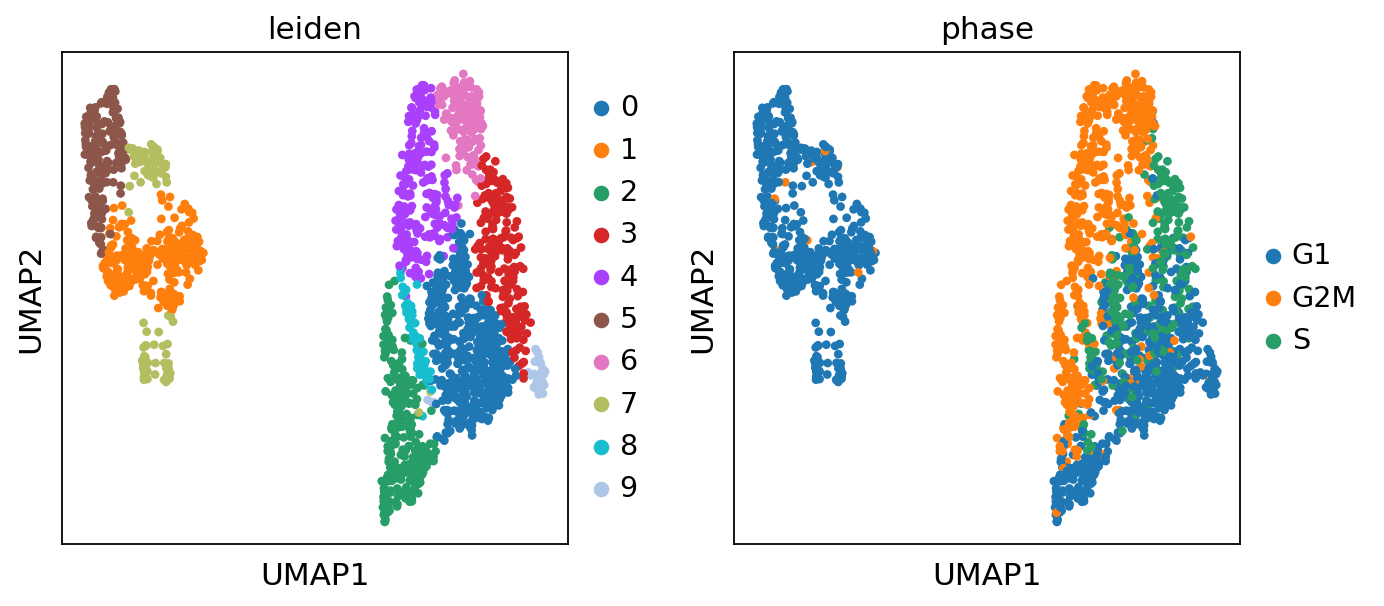

In [39]:
sc.pl.umap(adata,color=["leiden","phase"])

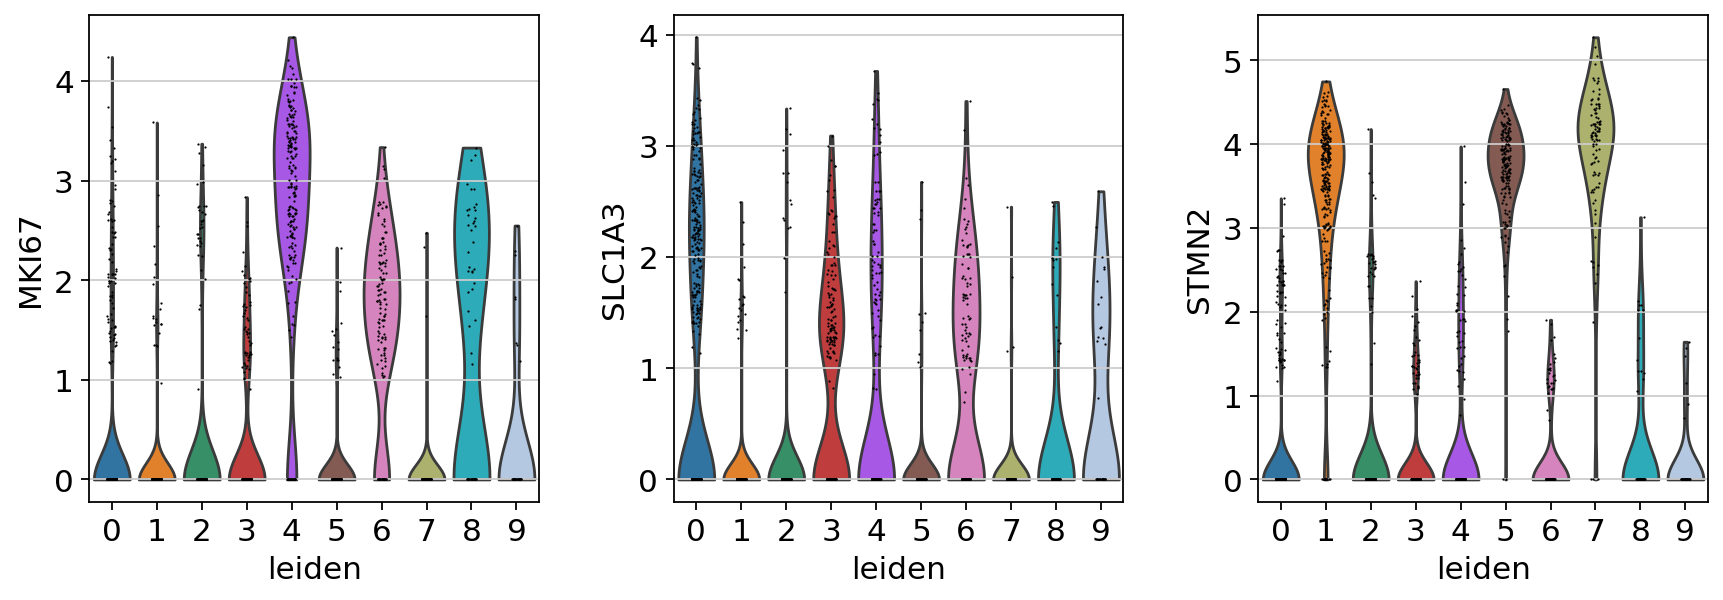

In [40]:
sc.pl.violin(adata, ['MKI67', 'SLC1A3','STMN2'], groupby='leiden',use_raw=False)

In [41]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0        1       2      3         4        5          6        7  \
0    MEIS2     NFIA   RAB13  RPLP0      ASPM   BCL11B      HMGB1    STMN2   
1      ID4    PRDX1  IFITM2  RPL41     TOP2A  NEUROD6   HIST1H4C   MLLT11   
2     SOX9   ELAVL4  LGALS1   RPS6     H2AFX    GPM6A      H2AFZ     GNG3   
3    SFRP1     SOX4   ANXA2  RPS15     MKI67     SYT1     TUBA1B   SEZ6L2   
4   HMGCS1   TMSB10   FCGRT   PCNA  MIS18BP1     NFIB      HMGN2    RAB3A   
5      QKI   MLLT11    HBG2  RPS19     CDC20     ZEB2      HMGB2      INA   
6    CCND2    NRXN1    HBA2  RPLP1     HMGB2    GAP43   HIST1H1D   PCSK1N   
7  ZFP36L1  NEUROD1    HBA1   RPS2      SMC4  CNTNAP2      RPLP1   TMSB10   
8     VCAN     MAP2    HBG1  RPL35     CENPF  C4orf48  HIST1H2AJ  GDAP1L1   
9     FZD8     NFIB  S100A6   SOX2     CENPE  NEUROD2   HIST1H1C     CHL1   

          8         9  
0   NEUROG2     RSPO3  
1   GADD45G     CXCR4  
2     SYNE2       VIM  
3      DLL1     MASP1  
4      HES6    ADGRG1  
5   NEUROD4      EMX2  
6      CHD7      HES1  
7  IVNS1ABP   C1orf61  
8     CNTLN  MIR99AHG  
9    PHLDA1      HEY2

In [42]:

marker_genes = ['leiden','MEIS2', 'ID4','NFIA','PRDX1','RAB13','RPLP0','RPL41','ASPM','TOP2A','BCL11B','NEUROD6', 'HMGB1', 'H2AFZ','STMN2', 'MLLT11', 'NEUROG2','GADD45G', 'RSPO3', 'VIM']



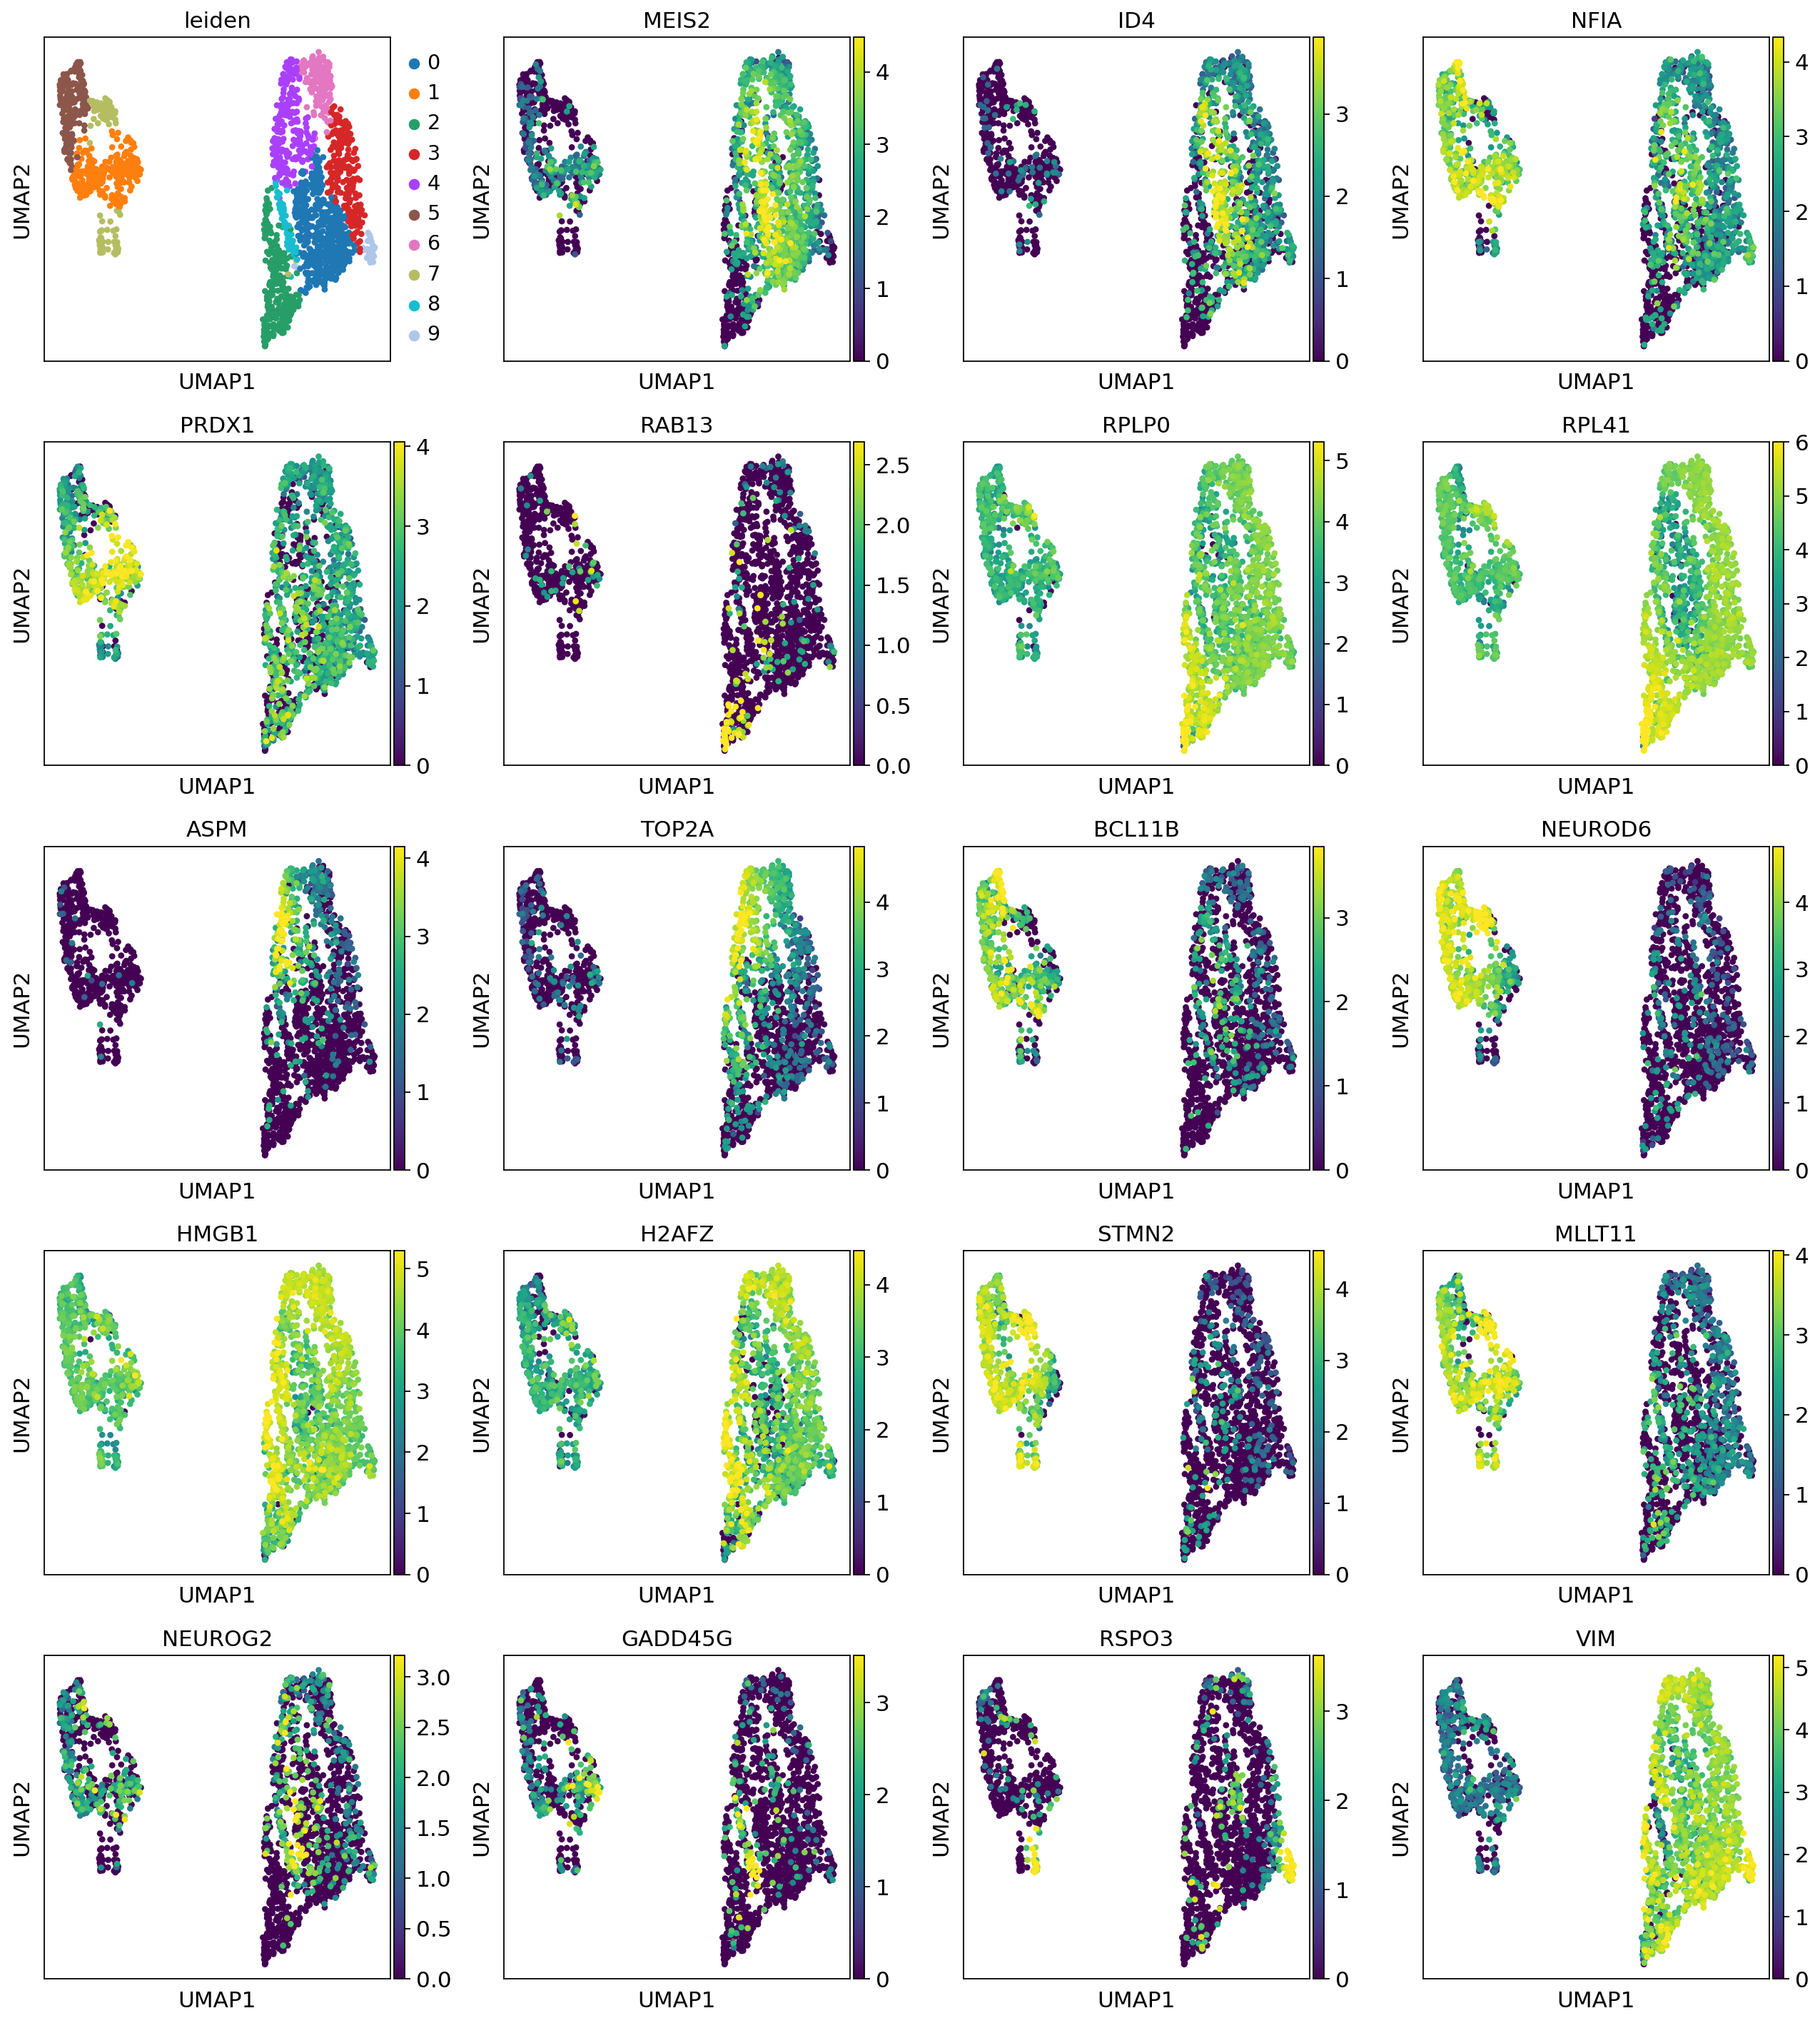

In [43]:
sc.pl.umap(adata,color=marker_genes,vmin="p1",vmax="p99",use_raw=False)

In [44]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99577224 0.96933854 0.96549594 0.9612766  0.94581395
     0.9446645  0.93061364 0.927668   0.91490585 0.9103481  0.89426017
     0.89185244 0.88842267 0.87980634]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


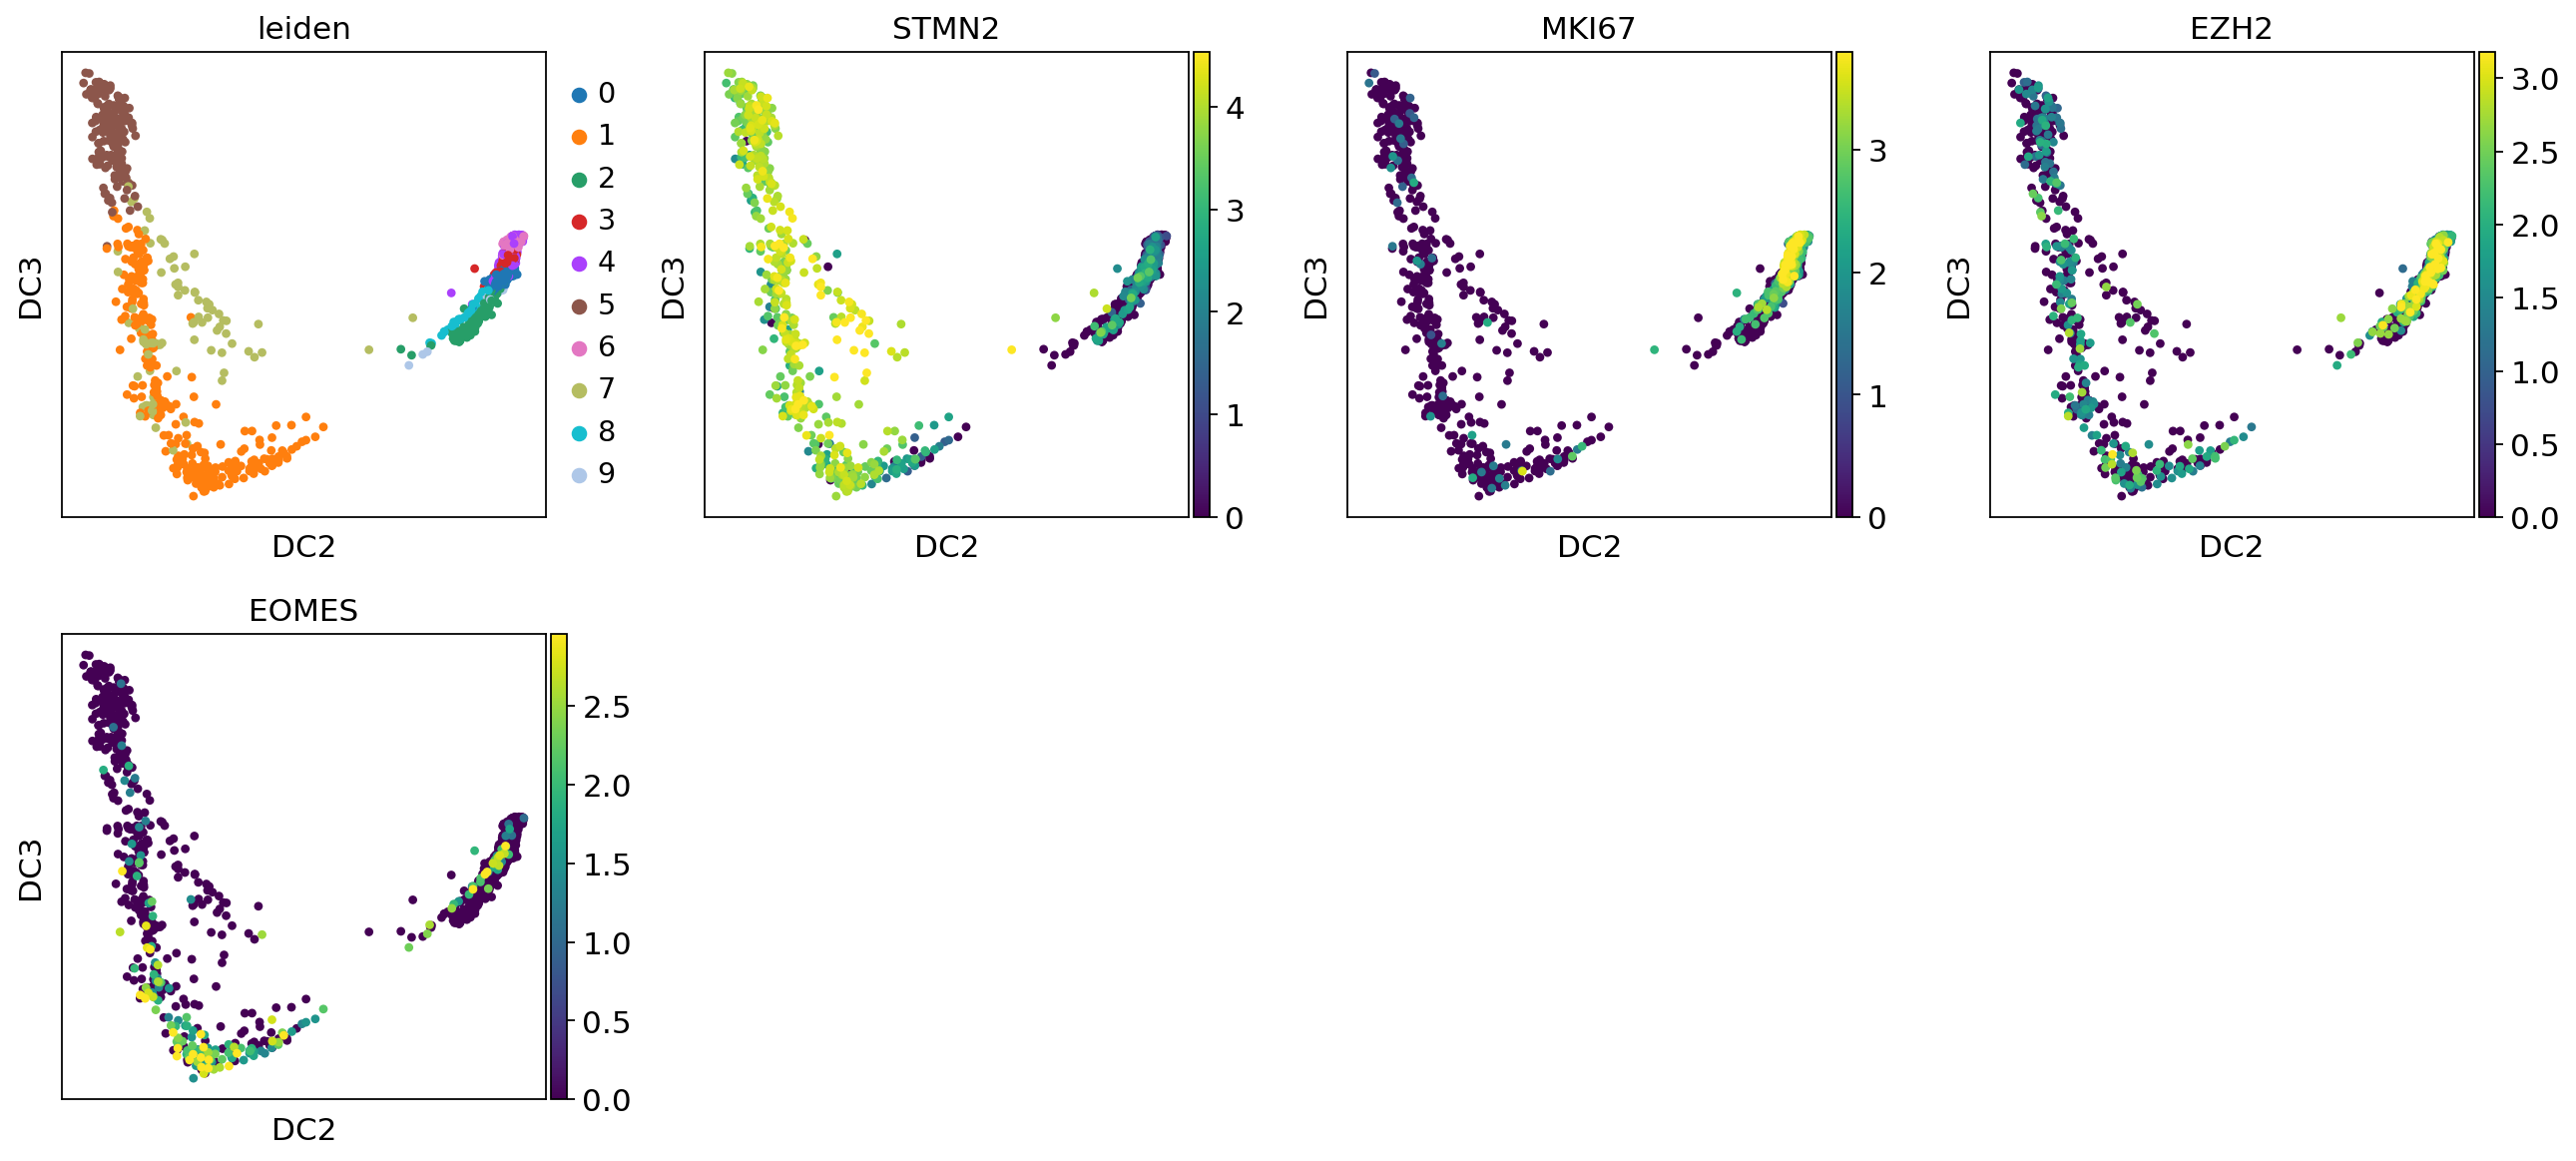

In [45]:
sc.pl.diffmap(adata,color=["leiden", 'STMN2','MKI67', 'EZH2', 'EOMES'],dimensions=(1,2),vmin='p1',vmax='p99',use_raw=False)

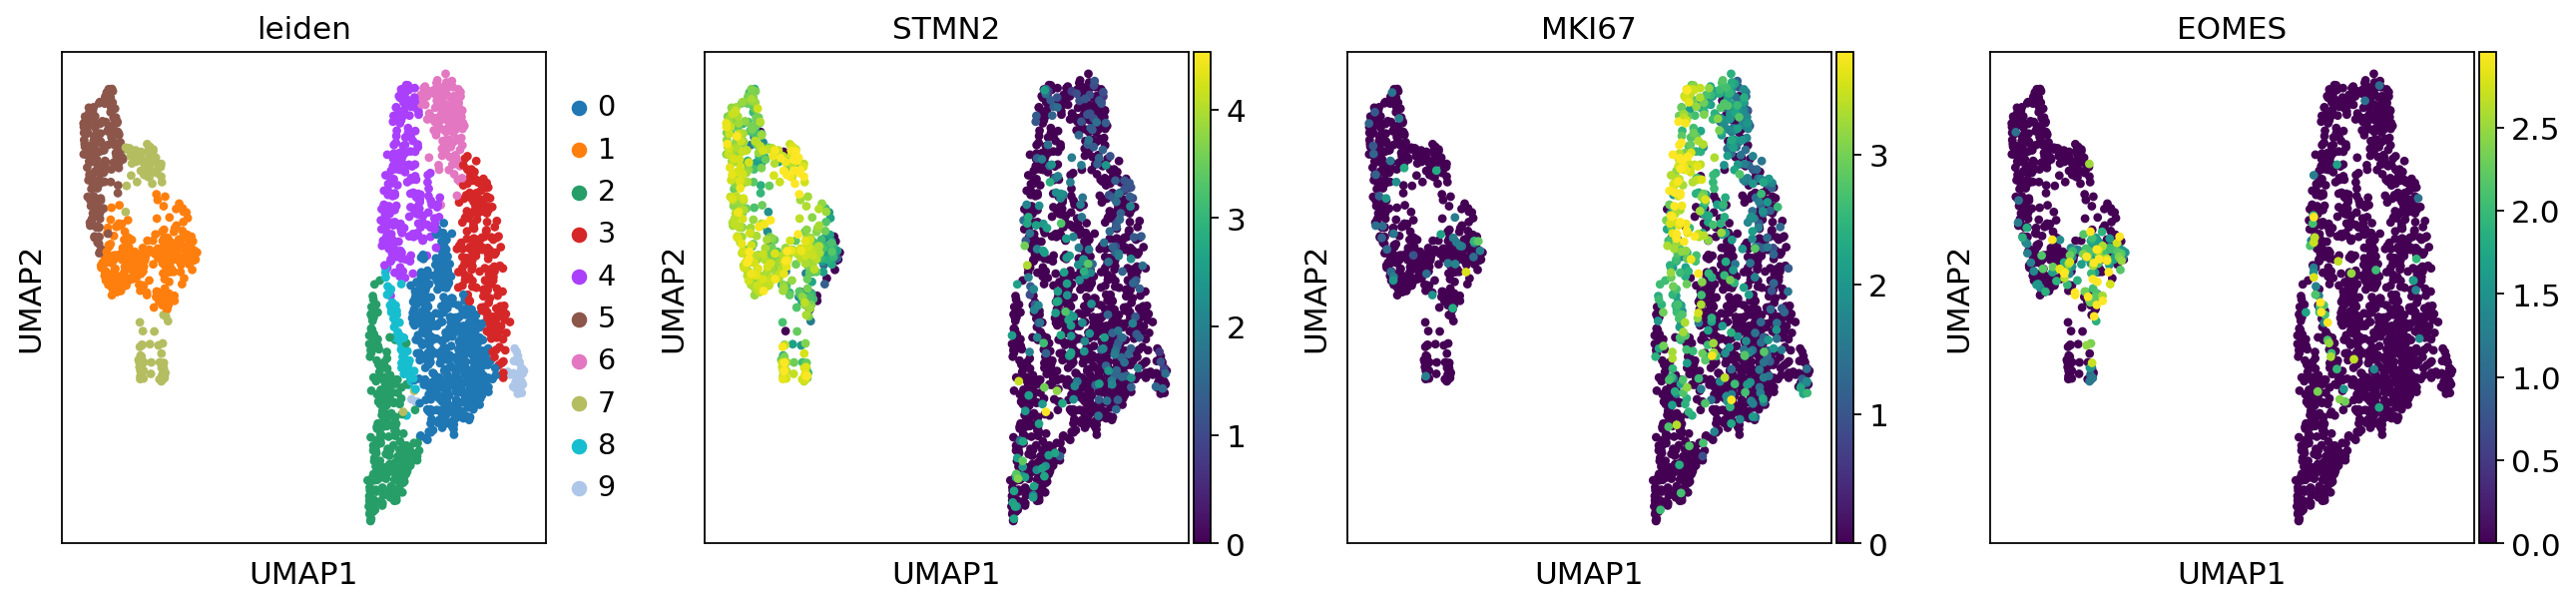

In [46]:
sc.pl.umap(adata,color=["leiden", "STMN2", "MKI67", "EOMES"],vmin="p1",vmax="p99",use_raw=False)

In [47]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: ExcDeepLayer, MatUpperEnr, IP, etc.


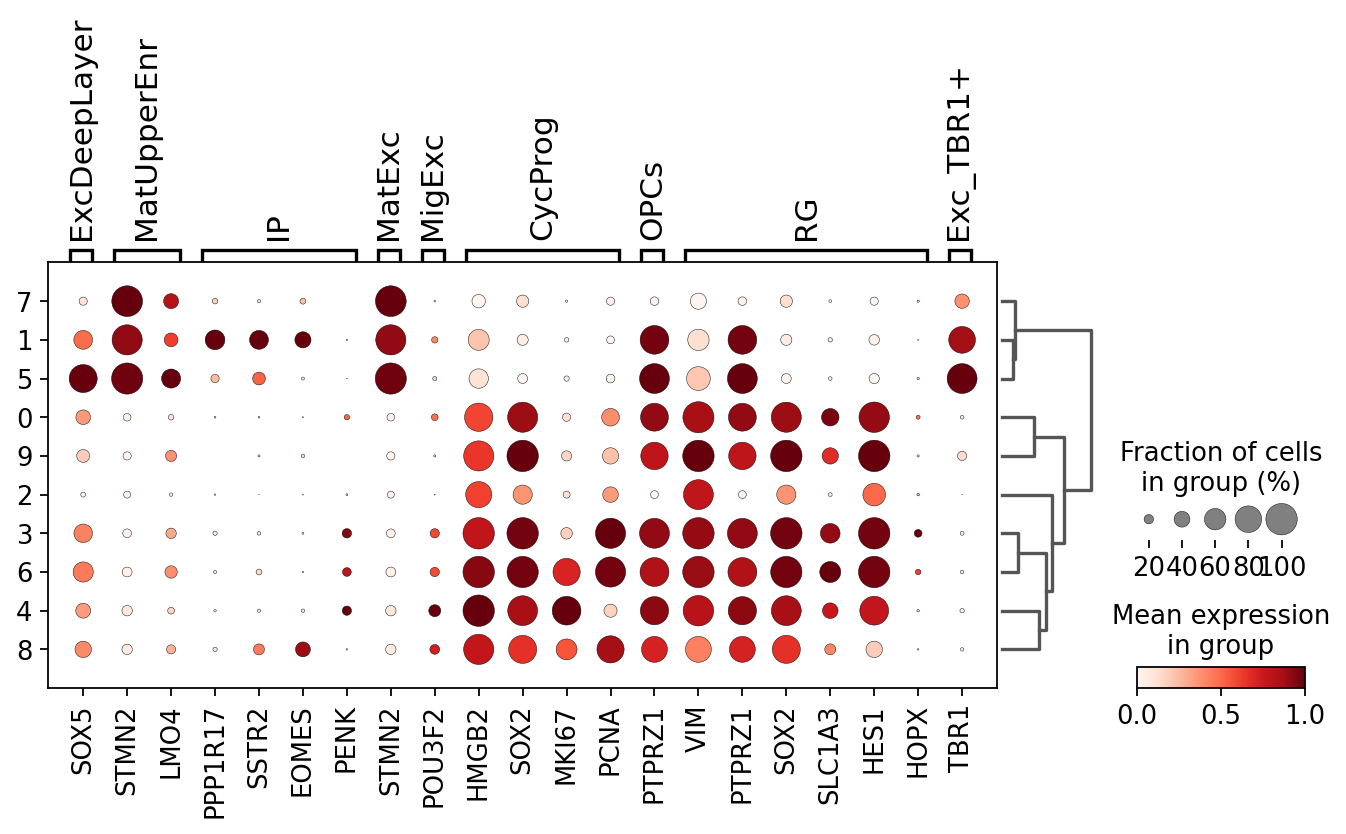

In [48]:
geschwind_ext = {
  'ExcDeepLayer' : ['SOX5'],
  'MatUpperEnr' : ['STMN2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_TBR1+' : ['TBR1']
}
 
sc.pl.dotplot(adata,geschwind_ext , 'leiden', dendrogram=True,save="combo_markersDotplot",use_raw=False,log=True,standard_scale='var')

In [49]:
cluster2annotation = {
    "0": "RG", "1": "Neu","2":"RG", "3": "RG",
    "4": "RG", "5" : "Neu", "6" : "RG", "7" : "Neu",
    "8" : "IP", "9" : "RG"
    
}
 
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [50]:
cluster2annotation = {
     "0": "vRG", "1": "MatExc","2":"vRG", "3": "oRG",
    "4": "vRG", "5" : "MatExc", "6" : "vRG", "7" : "MatExc",
    "8" : "IP", "9" : "vRG"
}
 
adata.obs['celltype2'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [51]:
new_cluster_names = [
    '0/vRG', '1/MatExc',
    '2/vRG', '3/oRG',
    '4/vRG','5/MatExc', '6/vRG', '7/MatExc',
    '8/IP','9/vRG']
adata.rename_categories('leiden', new_cluster_names)

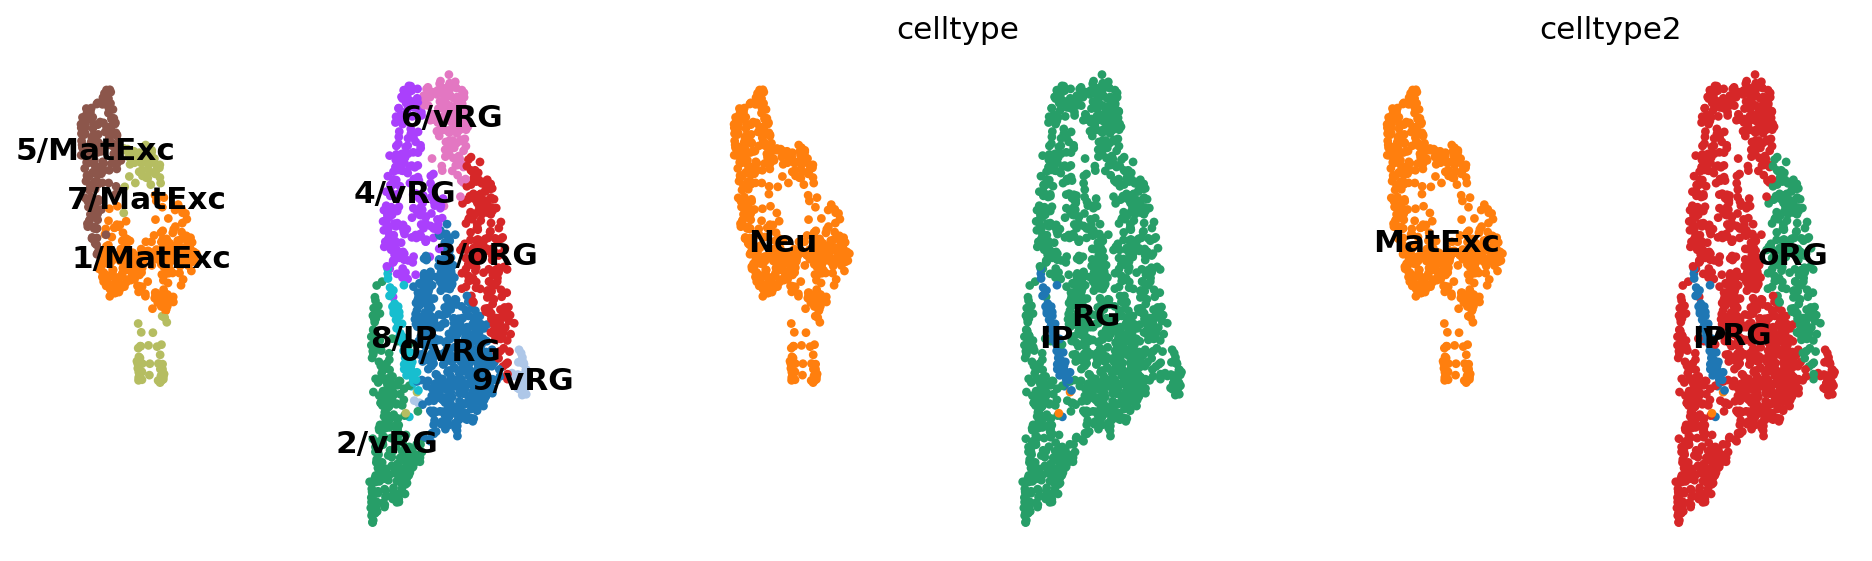

In [52]:
sc.pl.umap(adata, color=['leiden','celltype','celltype2'], legend_loc='on data', title='', frameon=False, save='.pdf')

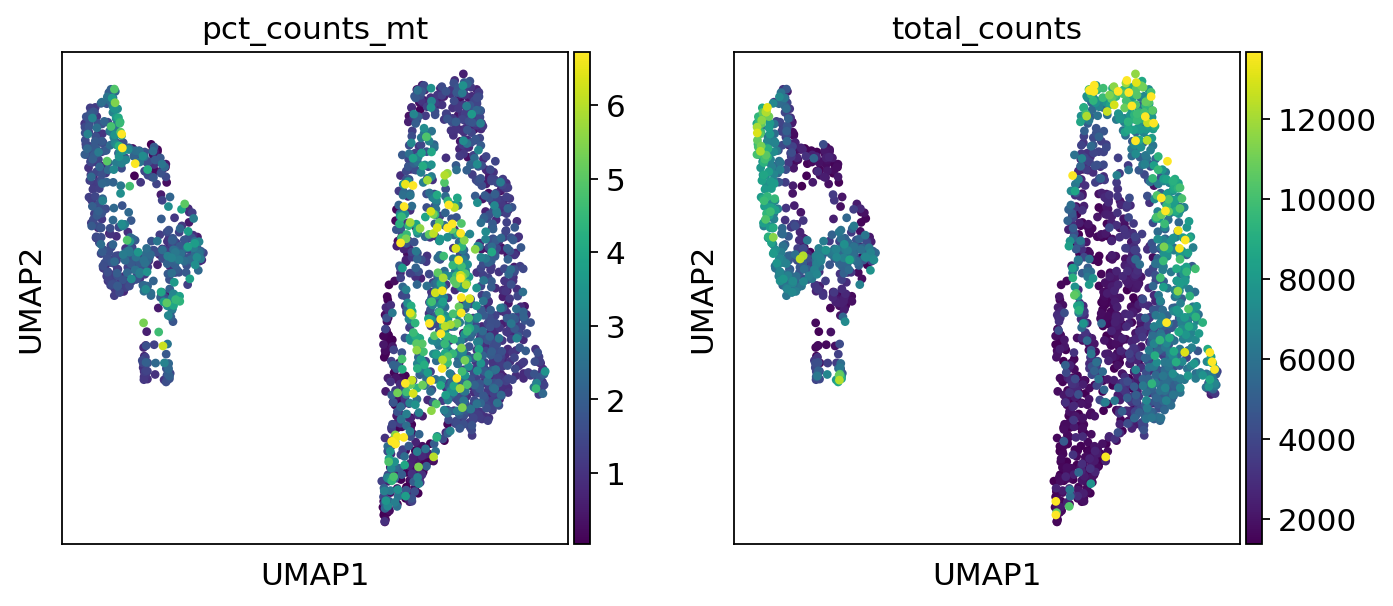

In [53]:
sc.pl.umap(adata,color=['pct_counts_mt','total_counts'],vmin='p1',vmax='p99')

In [54]:
sc.tl.dendrogram(adata,"leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [55]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99577224 0.96933854 0.96549594 0.9612766  0.94581395
     0.9446645  0.93061364 0.927668   0.91490585 0.9103481  0.89426017
     0.89185244 0.88842267 0.87980634]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [56]:
adata.obs.leiden.value_counts()

0/vRG       474
1/MatExc    280
2/vRG       251
3/oRG       214
4/vRG       209
5/MatExc    183
6/vRG       132
7/MatExc    102
8/IP         57
9/vRG        36
Name: leiden, dtype: int64

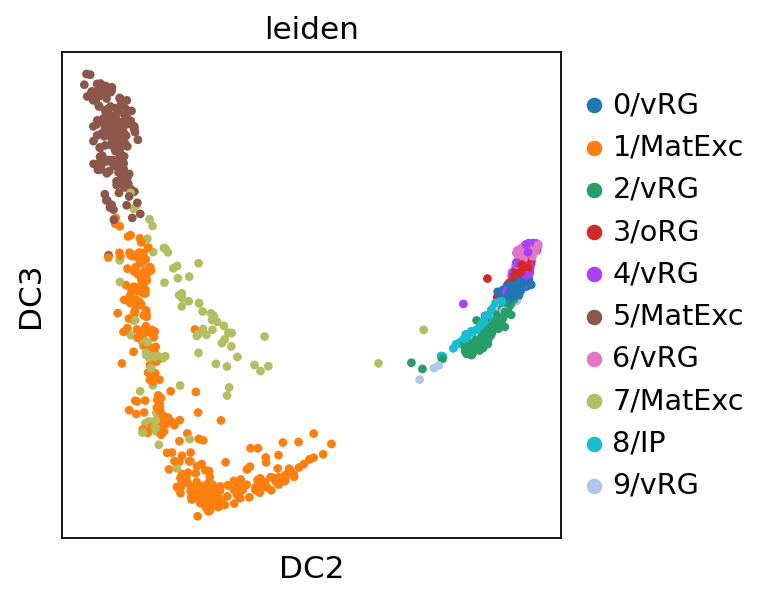

In [57]:
sc.pl.diffmap(adata,color="leiden",dimensions=(1,2))

In [58]:
adata.obs.leiden

AAACCTGCAGACAAAT-1        8/IP
AAACCTGCATGTTGAC-1       3/oRG
AAACCTGGTAAGGGAA-1    5/MatExc
AAACCTGGTTGCTCCT-1       0/vRG
AAACCTGTCACCGTAA-1       2/vRG
                        ...   
TTTGTCAAGGTGCACA-1    5/MatExc
TTTGTCAAGTTTCCTT-1       4/vRG
TTTGTCACAAGACGTG-1       0/vRG
TTTGTCACAGGTCTCG-1       0/vRG
TTTGTCATCCTACAGA-1       3/oRG
Name: leiden, Length: 1938, dtype: category
Categories (10, object): ['0/vRG', '1/MatExc', '2/vRG', '3/oRG', ..., '6/vRG', '7/MatExc', '8/IP', '9/vRG']

In [ ]:
adata.write_h5ad("/group/testa/Project/CBOProgPools/h5ad/CS22_01_20240208_v1.h5ad")

In [59]:
adata=sc.read_h5ad("/group/testa/Project/CBOProgPools/h5ad/CS22_01_20240208_v1.h5ad")

In [60]:
adata.obs['stage'] = 'CS22'

In [61]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/CS22_01_20240208_v1.h5ad')